# Real-time Anomaly Detection in Financial Transactions


## Authors and Team

- **Author 1**: Ferris Atassi, Developer
- **Author 2**: Charles Hang, Developer

# Executive Summary

### Decisions to be impacted

Our project will impact decisions to accept or reject financial transactions based on suspicion of fraud. More broadly, it will help fraud detection specialists at financial institutions develop tools to detect fraudulent financial transactions.

### Business Value

<p style="font-size:12px">According to global card industry research company Nilson Report, $33 billion was lost to credit card fraud in 2022. Reducing that fraud will lead to savings for  companies, which will sell fewer goods and services to fraudulent buyers and thus incur fewer costs associated with such sales (such as chargebacks). For example, the dataset used in this project was provided by Vesta Corporation, which guarantees that credit card transactions will go through in exchange for a cut of the revenues. Whenever a transaction does turn out to be fraudulent, Vesta is responsible for compensating the seller for the lost volume. Reducing credit card fraud by detecting it when it happens will reduce costs for transaction guarantee companies such as Vesta. </p>

<p style="font-size:12px">Similarly, reducing the number of fraudulent transactions will help consumers by protecting them from accidentally paying for fraudulent transactions and by also lowering how much they pay for goods and services (since providers will not need to raise prices as much to account for fraud costs).</p>

### Data Assets

<p style="font-size:12px">This project uses the IEEE-CIS dataset, which was used in the IEEE-CIS Fraud Detection competition on Kaggle in 2019. The dataset consists of 590,540 actual credit card transactions spanning a little over six months. The transactions were provided by Vesta Corporation, a leader in the credit card payment guarantee industry.</p>

### Literature Review

<p style="font-size:12px">Machine learning and artificial intelligence methods have been used to detect credit card fraud for at least 30 years. Bolton and Hand’s 2001 paper “Unsupervised Profiling Methods for Fraud Detection” outlines how supervised methods were used in the 1990s to detect fraudulent transactions. Reflecting the overall popularity of neural networks in that decade, neural networks were used in supervised learning models for fraudulent transaction detection. Building upon that work, Bolton and Hand outlined how unsupervised methods such as clustering and nearest neighbor methods could be used to build unsupervised learning models to detect fraudulent transactions. Their proposed models, “Peer Group Analysis” and “Break Point Analysis,” grouped accounts into peer groups and analyzed changes in their behavior over time, looking for moments (“break points”) in which individual accounts’ behavior suddenly diverged from that of their peers, which could be indicative of fraud.</p>

<p style="font-size:12px">Bhattacharyya et al.’s 2011 paper “Data mining for credit card fraud: A comparative study” outlined additional fraud detection methods being used in industry around that time. The paper compared the performance of three methods–logistic regression, random forests, and support vector machines. All three methods had strong performances, with precision scores around 0.8. However, these high precision scores were generated through extremely high specificity values (all around 0.98), meaning that all three methods were successful in labeling 98% of legitimate transactions as legitimate. However, all three methods had much lower sensitivity values (around 0.5 to 0.7), indicating that they had much more difficulty in detecting fraudulent transactions from the overall pool of transactions. </p>

**Comparison of Fraud Detection Techniques from Bhattacharya et al. (2011)**

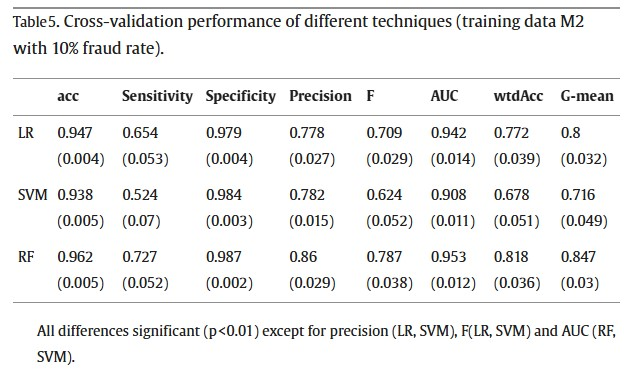

<p style="font-size:10px">A preference for higher specificity and lower sensitivity might have business value, since it prevents customers from regularly having their transactions declined incorrectly, thus reducing customer friction and improving customer satisfaction. However, it does also shift the burden of fraud onto credit card issuers, since it means allowing more fraudulent transactions to go through, which later have to be reversed, a cost usually incurred by the issue. In that context, it was notable that random forest models managed the highest sensitivity score of the three models (0.727) while also maintaining the highest specificity (0.987). Because of this, one of the models used in our project was the isolation random forest model, a variant of the random forest model outlined in Bhattacharyya et al.’s paper, which we hoped would have even stronger performance. Additionally, we also included a CART Tree, a simpler decision tree model, which reflects the ubiquity of decision tree models in the fraud detection space, as noted by Bhattacharyya et al.’s paper.</p>

<p style="font-size:10px">In the past decade, more exotic methods have been proposed for credit card fraud detection. Fiore et al.’s 2014 paper outlined a method for using generative adversarial networks (GANs) to account for the fact that most credit card fraud datasets are highly imbalanced, in that the overwhelming majority of transactions in the datasets are not fraudulent. To account for this, Fiore et al. used a generative adversarial network in which two neural networks competed against one another, with one generating new transactions while the other tries to discriminate whether the newly generated transactions are fraudulent or not. The GAN-based methods generated extremely high specificity values ranging around 0.99998, but their sensitivity levels were around 0.7, no higher than the best performances from techniques used in the previous decade. Also, the paper compared the performance of their GAN models with the performance of SMOTE, another classification technique used in imbalanced datasets, and found that the two methods’ performance was similar. In that context, we chose to use SMOTE as another classification tool in our project, since it is easier to configure than a GAN.</p>

<p style="font-size:10px">A final category of models popularly used in credit card fraud detection is gradient boosting models. Several papers published since 2020 in response to the publication of the IEEE-CIS credit card fraud dataset have proposed gradient boosting models as a solution to detecting fraudulent transactions in the dataset. For example, Xiao et al.’s paper presented at the 7th International Conference on Economic Management and Green Development compared the effectiveness of three different gradient boosting methods–Categorical Boost (CatBoost), Extreme Boost (XGBoost) and LightGBM (LGBM)–and managed to achieve an accuracy score of 96.77% using these methods. Similarly, the top two solutions in the original IEEE-CIS fraud detection competition on Kaggle also used those three gradient boosting techniques. In that context, we also implemented a gradient boosting technique, XGBoost, as one of our fraud detection methods to see if it would outcompete the performance of the older techniques outlined in this literature review.</p>

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

# Morphism 1: Elementary Data Analysis:

Function: F_{EDA} = Analyzes data structures, generates statistics on raw data, clean data (nulls), and generates visualizations. 

Risk Function: R_{EDA} = Minimization of information gaps and ensures a comprehensive understanding of the dataset.

Parameters: Visualization Choices/Settings

# Data Preprocessing (1)

<p style="font-size:10px">Data consists of two types of datasets, with both test and training verions of each, resulting in total: 4 data sets: train_identity, test_identity, train_transaction, and test_transaction. They key feature we are looking to analyze is the 'isFraud' field, indicating whether a transaction has been flagged as fraudulent or not. The first step was to combine the test and train datasets into their own, resulting in a train and test dataset. </p>

<p style="font-size:10px">The Train and Test datasets consists of multiple groupings of features: TransactionID: ID of the transaction, TransactionDT: timestamp of transaction, TransactionAMT: transaction amount, ProductCD: product code, card1-6: card type and other information, addr1-2: billing address of transaction, dist1-2: distance from billing adress to address of purchase, P_emaildomain: purchaser email domain, R_emaildomain: reciever email domain, C1-14: feature that is counted across different transactions (meaning not given in dataset), D1-15: times between transactions (meaning not given in dataset), M1-9: Matches of fields for each transaction (meaning not given in dataset), V1-???: (meaning not derived yet), id_01-id_38: identification information accumulated by anti-fraud software that developed dataset, DeviceType: type of device transaction was done on, and DeviceInfo: information of device. isFraud is a field only present in the train dataset flagging whether a transaction is considered to be fraud or not (0-not fraud, 1-fraud). </p>

In [22]:
### reading data into notebook
train_identity = pd.read_csv(r'train_identity.csv')
test_identity = pd.read_csv(r'test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv')

trainDF = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
testDF = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#fixing timestamps
trainDF['TransactionDay'] = (trainDF['TransactionDT'] // 86400).astype(int)
trainDF['TransactionDayOfWeek'] = trainDF['TransactionDay'] % 7
trainDF['TransactionWeek'] = (trainDF['TransactionDT'] // 604800).astype(int)

In [23]:
#showing columns with # entries > 80% being null/empty
print("Top Features filled with N/A and Their Percentages")
trainDF.isnull().mean()[trainDF.isnull().mean() > .8]
#much of dataset is empty

Top Features filled with N/A and Their Percentages


dist2    0.936284
D6       0.876068
D7       0.934099
D8       0.873123
D9       0.873123
           ...   
id_27    0.991247
id_30    0.868654
id_32    0.868619
id_33    0.875895
id_34    0.868248
Length: 74, dtype: float64

**Statistic: Feature N/A Occurence Percentage**

It can be seen that multiple of the preconstructed features provided by Vesta Co. are filled with at least 80% n/a values. Much of this data set is empty and needs to be dealt with before model construction.

# -------------------------------------------------------------------------------------

# Fraud Count Analysis

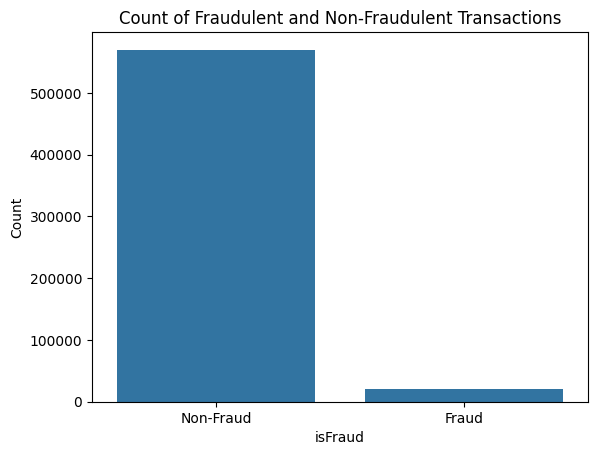

Percentage of Fraudulent Transactions: 0.03499000914417313


In [24]:
#Showing Distribution of Fraudulent vs Non-Fraudulent Transactions
fraud_counts = trainDF['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index.map({0:"Non-Fraud", 1:"Fraud"}), y=fraud_counts.values)
plt.ylabel('Count')
plt.title('Count of Fraudulent and Non-Fraudulent Transactions')
plt.show()
print("Percentage of Fraudulent Transactions:", trainDF.isFraud.mean())
#Around 4 percent is flagged fraud 

**Visualization: Histogram of Fraudulent Transaction Frequency Among All Transactions**

It can be seen that the ratio of Fraud to Non-Fraudulent Transactions is 0.03499, indicating under 4% of the transactions provided were flagged as fraudulent.

In [25]:
#Correlation between transaction amount and fraudulent classification of transactions.
correlation = trainDF['TransactionAmt'].corr(trainDF['isFraud'])
print("Correlation between transaction amount and fraud flag:", correlation)
#Violates our hypothesis of there being immense correlation between TransactionAmt and fraud. Potentially indicates 
#most fraudulent transactions contain smaller transaction amounts to attempt to have less attention towards it.

Correlation between transaction amount and fraud flag: 0.01131982533321524


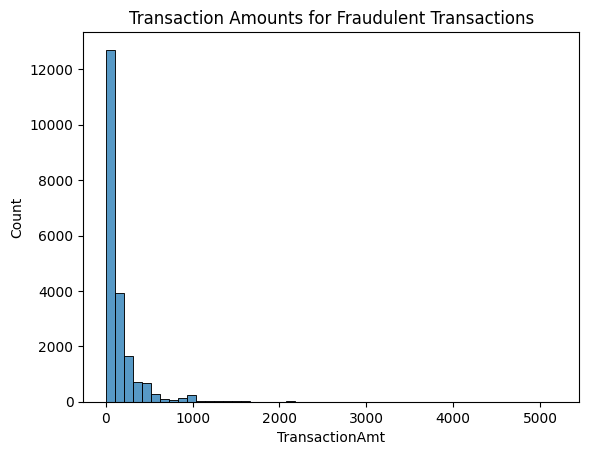

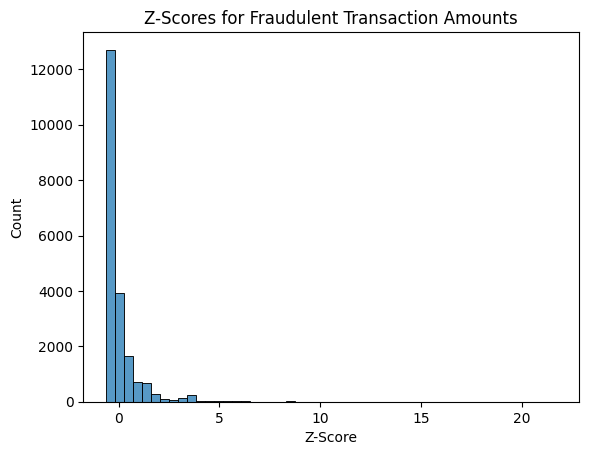

In [26]:
#Graphs of Transaction Amounts of Fraudulent Transactions + Z-scores for Fraudulent Transaction Amounts
fraudulent_transactions = trainDF[trainDF['isFraud']==1]
transaction_amounts = fraudulent_transactions['TransactionAmt']
z_scores = stats.zscore(transaction_amounts)

outliers = fraudulent_transactions[(z_scores > 3)|(z_scores < -3)]

sns.histplot(transaction_amounts, bins=50)
plt.title('Transaction Amounts for Fraudulent Transactions')
plt.show()

sns.histplot(z_scores, bins=50)
plt.title('Z-Scores for Fraudulent Transaction Amounts')
plt.xlabel('Z-Score')
plt.show()
#This further proves the hypothesis made in the last cell, most fraudulent transactions are in the lower end of transaction amounts.

**Visualization: Histogram of Fraudulent Transaction Amounts and a Histogram Displaying Z-Scores of Fraudulent Transaction Amounts**

It can be seen that this distribution is right skewed with most fraudulent transactions having lower transaction amounts (< $1000) and Z-scores under 5.

# -------------------------------------------------------------------------------------

# Transaction Amount Analysis

In [27]:
#Ratio of Fraud Transactions in Long-Tail Transactions by Transaction Amount
long_tail_threshold = trainDF['TransactionAmt'].quantile(0.99)
long_tail_data = trainDF[trainDF['TransactionAmt'] > long_tail_threshold]
long_tail_fraud_ratio = long_tail_data['isFraud'].mean()
print(f"Fraud Ratio in Long-Tail Transactions: {long_tail_fraud_ratio}")
#Only 2% of fraudulent transactions took place in long-tail transaction amounts, thus most fraud was not in long-tail data. 

Fraud Ratio in Long-Tail Transactions: 0.024109200496365894


In [28]:
mean_transaction_amt = trainDF['TransactionAmt'].mean()
std_transaction_amt = trainDF['TransactionAmt'].std()
trainDF['TransactionAmt_Zscore'] = (trainDF['TransactionAmt'] - mean_transaction_amt) / std_transaction_amt
print(trainDF[['TransactionAmt', 'TransactionAmt_Zscore']].head())
outliersZScore = trainDF[(trainDF['TransactionAmt_Zscore'] > 3) | (trainDF['TransactionAmt_Zscore'] < -3)]
print(f"Number of outliers: {outliersZScore.shape[0]}")
print(outliersZScore[['TransactionID', 'TransactionAmt', 'TransactionAmt_Zscore']])

   TransactionAmt  TransactionAmt_Zscore
0            68.5              -0.278167
1            29.0              -0.443327
2            59.0              -0.317889
3            50.0              -0.355520
4            50.0              -0.355520
Number of outliers: 10093
        TransactionID  TransactionAmt  TransactionAmt_Zscore
60            2987060         2454.00               9.696222
110           2987110         1153.95               4.260378
133           2987133         2594.95              10.285570
135           2987135         3000.00              11.979188
163           2987163          973.95               3.507752
...               ...             ...                    ...
590402        3577402         1331.00               5.000670
590405        3577405         2286.27               8.994899
590408        3577408         1615.74               6.191241
590464        3577464         1731.30               6.674427
590519        3577519         1659.95               6.376

**Statistics: Z-scores of All Transaction Amounts in Dataset**

Based on Z-score on Transaction amounts, it can be seen while using a Z-Score Outlier Threshold of < -3 & > 3 that there are 10093 outliers found.

# -------------------------------------------------------------------------------------

# Credit Card Distributor Analysis

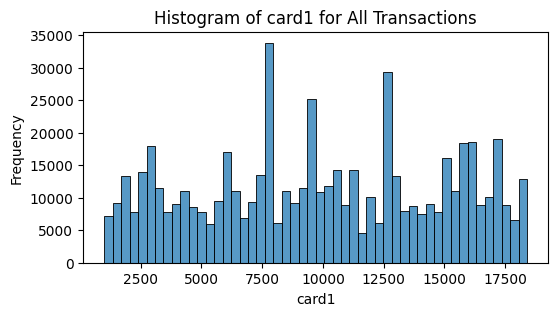

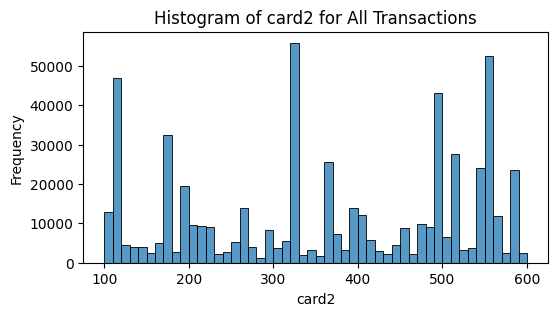

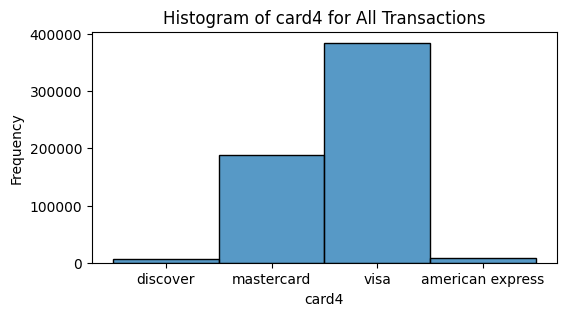

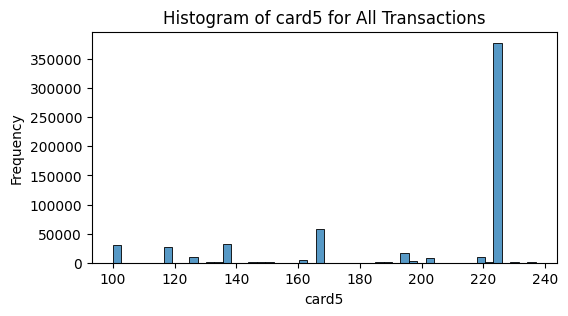

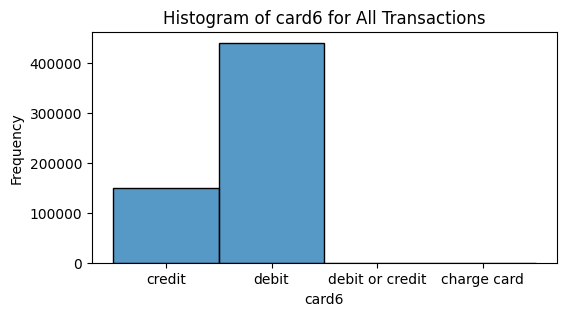

In [29]:
card_columns = ['card1', 'card2', 'card4', 'card5', 'card6'] 
#categorical variables, with all transactions having card1, card2 less than card1, card3 less than card2
#card4 is credit card distributor, #card5-country, #card6- card type.
for card in card_columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(trainDF[card].dropna(), kde=False, bins=50)  # Drop NaNs before plotting
    plt.title(f'Histogram of {card} for All Transactions')
    plt.xlabel(f'{card}')
    plt.ylabel('Frequency')
    plt.show()
#most used digital payments companies are Visa and Mastercard, this is expected to hold for fraudulent transactions as well. 

**Visualization: Histograms of Debit/Credit Card Data Used in Transactions**

<p style="font-size:10px">Card 1 refers to a code that is assigned to various types of credit/debit cards (e.g. Chase Freedom vs. Chase Freedom Student) and a histogramis constructed to visualize frequencies of usage. Multiple peaks, does not provide much support towards identifying fraudulent claims.</p>

<p style="font-size:10px">Card 2 refers to another form of mapping of credit/debit card types to a 3 digit code, a histogram of frequencies. Similar to card1, trends are difficult to establish due to its multi-peak qualities. </p>

<p style="font-size:10px">Card 4 refers to Credit Card distributor with a histogram couting frequencies of each one within dataset for all transactions. It can be seen that across all transactions, Visa and Mastercard are the most widely used, with Visa leading by an almost 2x margin. </p>

<p style="font-size:10px">Card 5 refers to 3 digit codes referring to country of origin for card that was used within transaction, another histogram is constructed to visualize frequency. Most transactions take place in the country of 3 digit area code: 225. </p>

<p style="font-size:10px">Card 6 refers to either credit/debit and another histogram is consrtucted to visualize this binary feature and how the whole dataset is distributed across the two categories. It can be seen that debit seems to be the most widely utilized form of cards utilized in transactions. Credit has a frequency of nearly 1/3 debit's.</p>

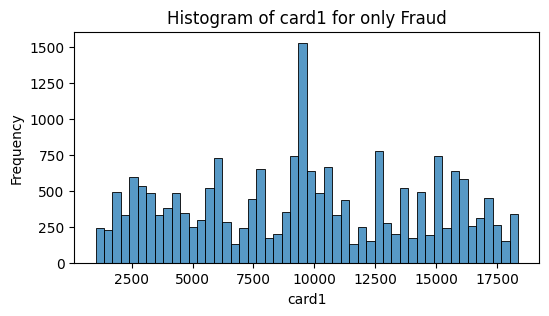

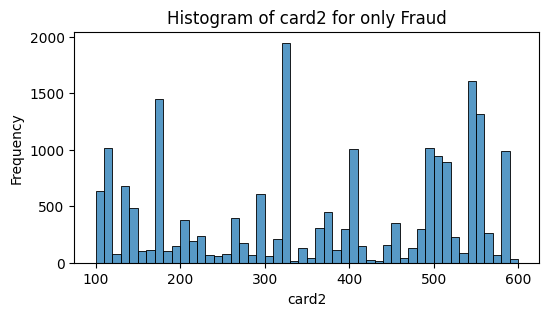

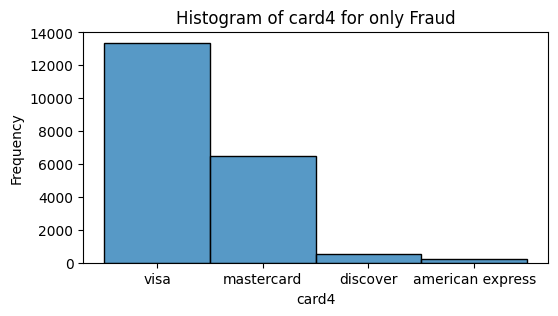

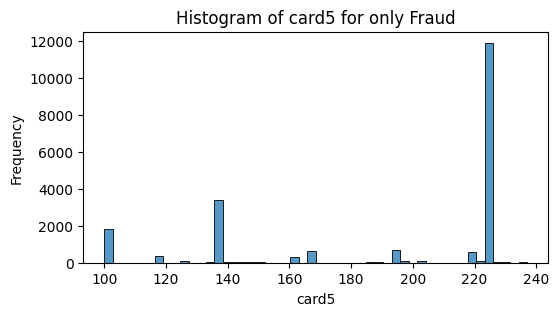

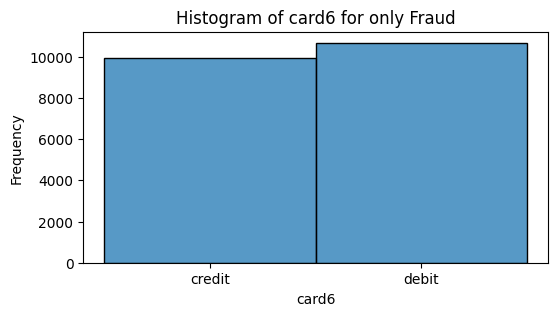

In [30]:
fraudDF = trainDF[trainDF['isFraud'] == 1]
for card in card_columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(fraudDF[card].dropna(), kde=False, bins=50)  # Drop NaNs before plotting
    plt.title(f'Histogram of {card} for only Fraud')
    plt.xlabel(f'{card}')
    plt.ylabel('Frequency')
    plt.show()
#Like before Visa and Mastercard hold the highest representation in fraudulent transactions as well. 
#credit and debit hold similar rates of fraud. 

**Visualization: Histograms of Debit/Credit Card Data Used in Only Fraudulent Transactions**

<p style="font-size:10px">Repetition of Graphs above but only centered on fraudulent transactions</p>

<p style="font-size:10px">Card 1: It can be seen that Fraudulent Transactions have a frequency peak in card1 feature around 8500 - 9500.</p>

<p style="font-size:10px">Card 2: Multiple peaks, indicating a higher difficulty in relating this field to whether a Fraudulent Transactions tends to show trends for Card2.</p>

<p style="font-size:10px">Card 4: Similar to distribution of all transactions, Visa and Mastercard remain the most used across fraudulent transactions as well.</p>

<p style="font-size:10px">Card 5: Exactly the same as visualized for All transactions, with a frequency peak around 3 digit code: 230.</p>

<p style="font-size:10px">Card 6: It can be seen that when comparing credit to debit frequencies of fraudulent transactions to all transactions, debit usage is seen to decrease immensely, indicating that credit is a high relevancy feature with regard to fraud classification for transactions.</p>

# -------------------------------------------------------------------------------------

# Email Domain Analysis (For Purchaser and Merchant)

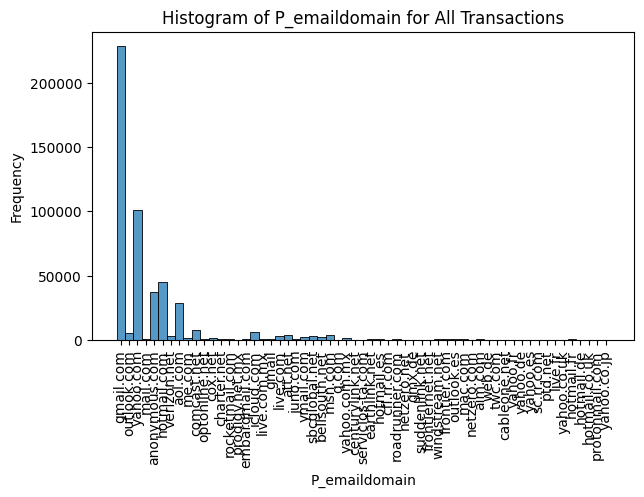

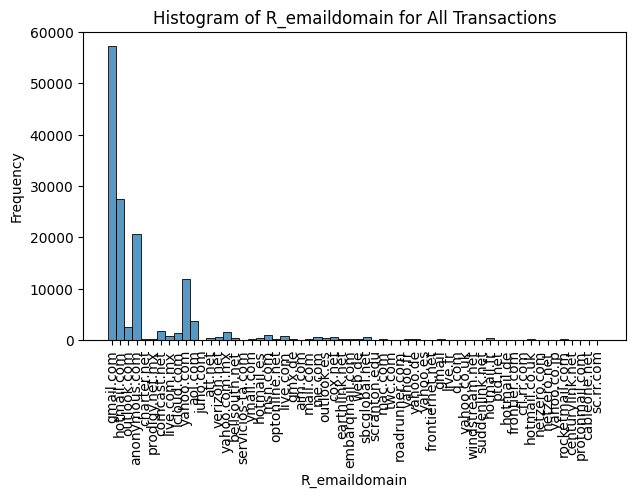

In [31]:
email_columns = ['P_emaildomain', 'R_emaildomain']
for email_col in email_columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(trainDF[email_col].dropna(), kde=False)  # Drop NaNs before plotting
    plt.title(f'Histogram of {email_col} for All Transactions')
    plt.xlabel(f'{email_col}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
#We expect the two graphs to look similar as gmail has been dominating the email domain field for years and is used in practice
#by millions of corporations and individuals, whether they are purchasing or selling in a transaction.

**Visualization: Histograms of Email Domains for Purchaser and Reciever for All Transactions**

P_email_domain histogram refers to frequency of email domains utilized in transactions on the purchaser's side (non-merchant). It can be seen that the top 3 email domains of purchasers are: gmail.com, yahoo.com, and hotmail.com

R_email_domain histogram referes to frequency of email domains utilized in transactions on the reciever's side (merchant). It can be seen that the top 3 email domains of receievers are: gmail.com, hotmail.com, and anonymous.com

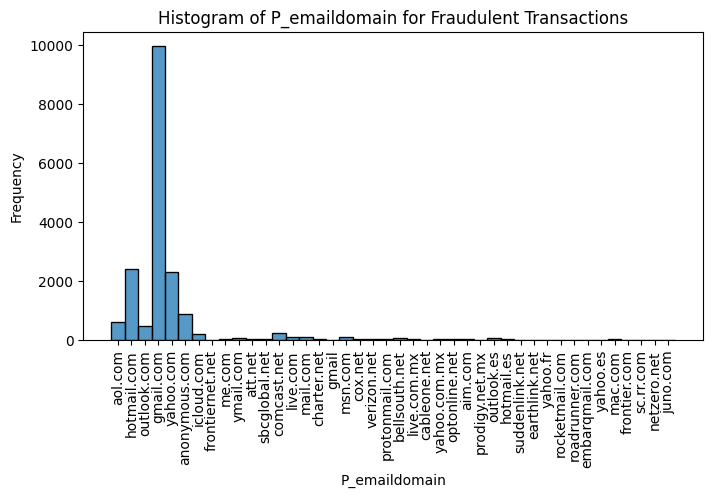

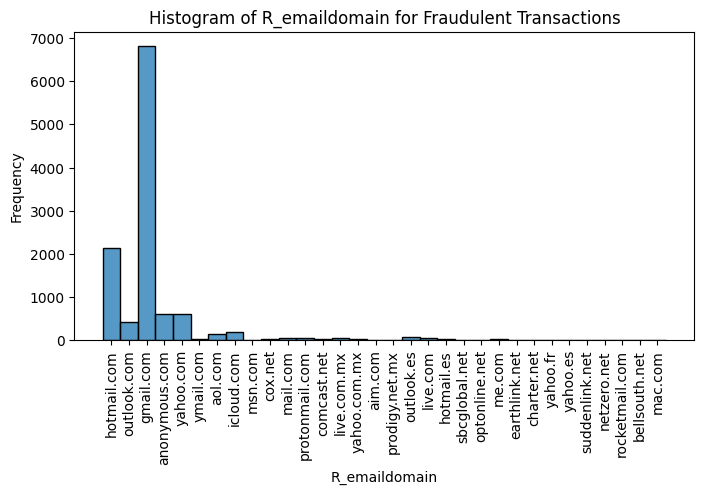

In [32]:
email_columns = ['P_emaildomain', 'R_emaildomain']
for email_col in email_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(fraudDF[email_col].dropna(), kde=False)  # Drop NaNs before plotting
    plt.title(f'Histogram of {email_col} for Fraudulent Transactions')
    plt.xlabel(f'{email_col}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
#Satisfies hypothesis from last cell, gmail is still #1 regardless of fraudulent or not transaction.

**Visualization: Histograms of Email Domains for Purchaser and Reciever for Fraudulent Transactions Only**

Similar to histogram above, but only centered on fraudulent transactions. 

From P_emaildomain histogram, it can be seen that the top 3 email domains for purchasers (non-merchant) in Fraudulent Transactions is gmail.com, hotmail.com, and yahoo.com.

From R_emaildomain histogram, it can be seen that the top 3 email domains for recievers (merchant) in Fraudulent Transactions is gmail.com, hotmail.com, and yahoo.com

# -------------------------------------------------------------------------------------

# Address/Distance Analysis

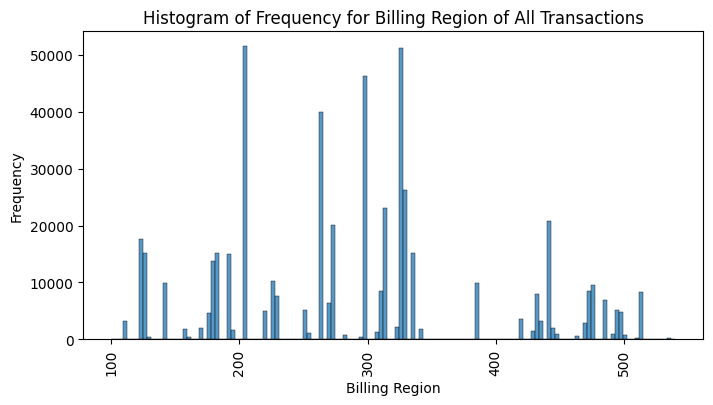

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(trainDF['addr1'].dropna(), kde=False)  # Drop NaNs before plotting
plt.title(f'Histogram of Frequency for Billing Region of All Transactions')
plt.xlabel('Billing Region')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
#We expect fraud to take place all over the country due to the ability to falsify billing addresses. The first graph refers to
#billing region, second refers to which country.

**Visualization: Histogram of Billing Region**

This visualization is a histogram of billing regions (not just in USA) represented as 3 digit codes across all transactions. This is another multi-peak feature indicating that billing region might not be a good indicator of fraud.

In [34]:
addressIsFraud = trainDF.groupby('addr1').isFraud.mean().sort_values(ascending=False)
print("Percentage Occurences of Fraud by Billing Region:")
addressIsFraud.head(10)

Percentage Occurences of Fraud by Billing Region:


addr1
305.0    0.666667
483.0    0.565217
501.0    0.500000
466.0    0.500000
471.0    0.500000
391.0    0.457143
431.0    0.342105
260.0    0.333333
432.0    0.289474
216.0    0.240741
Name: isFraud, dtype: float64

**Statistic: Highest Occurences of Fraud (Percentage) by Billing Region**

It can be seen that there are various billing regions that have higher frequencies of fraud than others. This can be attributed to the fact that there are billing regions with low numbers of occurrences in transactions, meaning that if there are only a few transactions and 1 is fraud, it would be displayed as a region of high fraud occurrence.

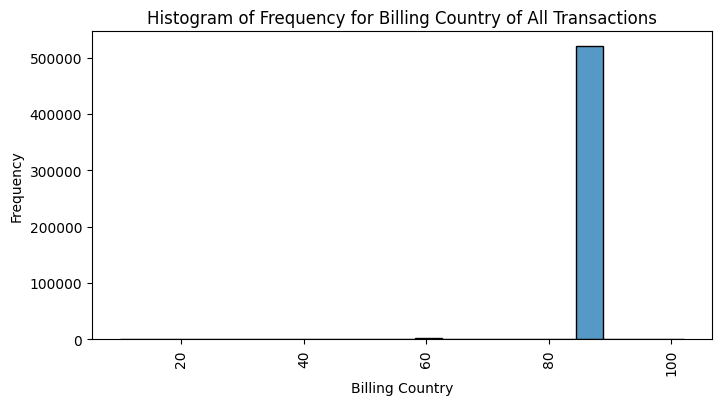

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(trainDF['addr2'].dropna(), kde=False)  # Drop NaNs before plotting
plt.title(f'Histogram of Frequency for Billing Country of All Transactions')
plt.xlabel('Billing Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
#it can be seen that nearly all transactions from this dataset were taken from one country, it can be assumed to be 
#the US due to usage of Mastercard, Visa, American Express, etc... (Country 87)

**Visualization: Histograms of Billing Countries**

This is a histogram of frequencies of billing countries across all transactions, it can be noted that most transactions occur at country 87. One can extrapolate that due to high usage of Visa, Mastercard, and American Express within datset that country 87 refers to the USA. Over 99% of data is found withing the USA, thus it is not a good feature to use as a fraud indicator. 

# -------------------------------------------------------------------------------------

# Date and Time

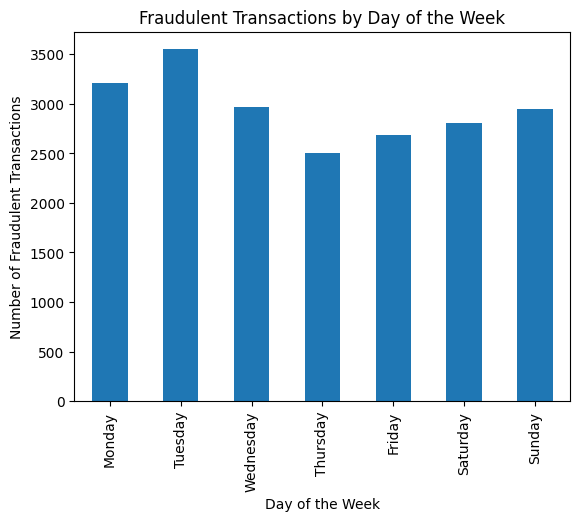

In [36]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
fraud_by_day_of_week = fraudDF.groupby('TransactionDayOfWeek').size()
fraud_by_day_of_week.index = fraud_by_day_of_week.index.map(day_mapping)
fraud_by_day_of_week.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Day of the Week')
plt.show()
#Seems that most fraudulent transactions would take place at the beginning of the week, peaking on Tuesdays.

**Visualization: Histograms of Fraudulent Transaction Occurrence by Day of Week**

This is a histogram visualization of fraud occurence by day of the week, it can be seen that this distribution is relatively uniform indicating that day of the week is not a good feature to use to predict on for identifying fraud.

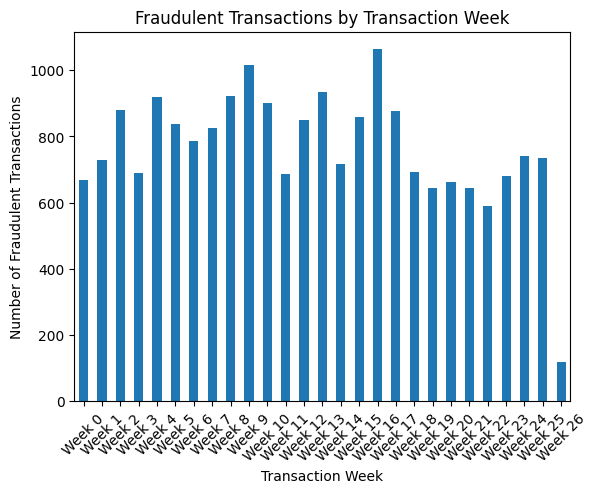

In [37]:
fraud_by_week = fraudDF.groupby('TransactionWeek').size()
fraud_by_week.index = fraud_by_week.index.map(lambda x: f'Week {x}')
fraud_by_week.plot(kind='bar')
plt.xlabel('Transaction Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Transaction Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
#The entirety of this program was 26 weeks it can be seen that the distribution is relatively unfirom with peaks at the 8th and
#16th weeks.

**Visualization: Histograms of Fraudulent Transaction Occurrence by Week Number**

This is a histogram of fraud occurence by week number. Data collection lasted 26 weeks, and it can be noted that most peaks of Fraud were detected between weeks 8 and 17 of total 26. Thus much of the fraud occurred within middle of data collection and dwindled down as week 26 was approached.

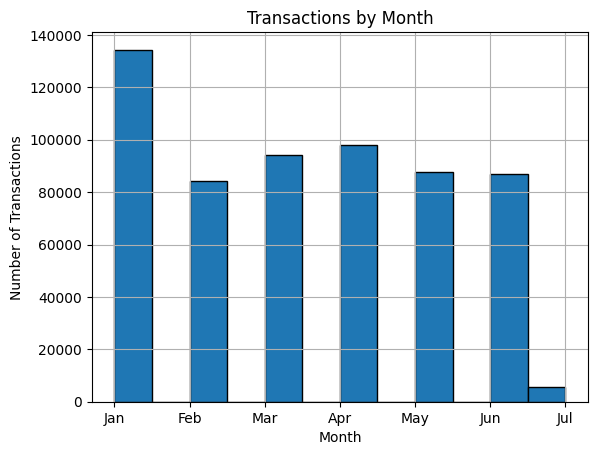

In [38]:
reference_date = pd.Timestamp("2017-01-01")  # Adjust the reference date if needed
trainDF['TransactionDate'] = trainDF['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

# Extract month from TransactionDate
trainDF['TransactionMonth'] = trainDF['TransactionDate'].dt.month

# Plot a histogram of transactions by month
trainDF['TransactionMonth'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Month')
plt.xticks(range(1, 8), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.show()
#Most transactions take place at the beginning of the year. This makes sense as that time of year is known to contain high
#amounts of spending across the world. 

**Visualization: Histograms of All Transaction Occurrence by Month**

This is a histogram visualizing frequency of transactions by month. Most transactions occurred at the beginning of the year, this aligned with our hypothesis that most fraud would occur in periods of high spending across the country. Our hypothesis is that most fraud occurs at the beginning of the year following the holidays.

/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_15130/3109281055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['TransactionDate'] = frauddf['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_15130/3109281055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['TransactionMonth'] = frauddf['TransactionDate'].dt.month


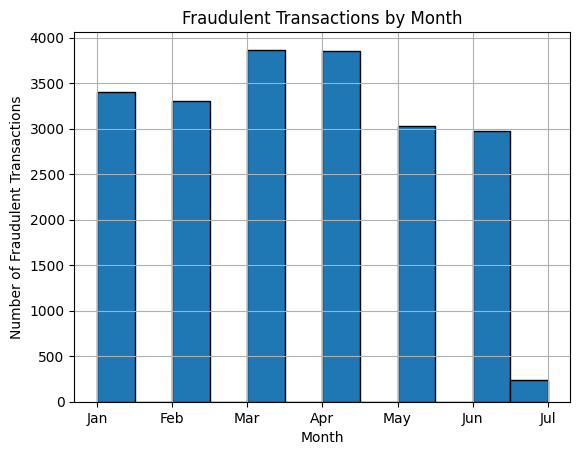

In [39]:
reference_date = pd.Timestamp("2017-01-01")  # Adjust the reference date if needed

# Filter for fraudulent transactions
frauddf = trainDF[trainDF['isFraud'] == 1]

# Convert TransactionDT to datetime format for fraudulent transactions
frauddf['TransactionDate'] = frauddf['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

# Extract month from TransactionDate
frauddf['TransactionMonth'] = frauddf['TransactionDate'].dt.month

# Plot a histogram of fraudulent transactions by month
frauddf['TransactionMonth'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Month')
plt.xticks(range(1, 8), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.show()
#All fraudulent transactions seem to be equivalently distributed across the year. This invalidates my previous 
#hypothesis as most fraudulent transactions are happening towards the middle of the year, not the beginning.

**Visualization: Histograms of Fraudulent Transaction Occurrence Month**

<p style="font-size:10px">This is a similar histogram to the one above, however only showing occurences of fraudulent transactions. This histogram violated our previously stated hypothesis that most fraud would take place at the begnning of the year, as the peak of fraudulent transactions takes place in March and April, not January/February.</p>

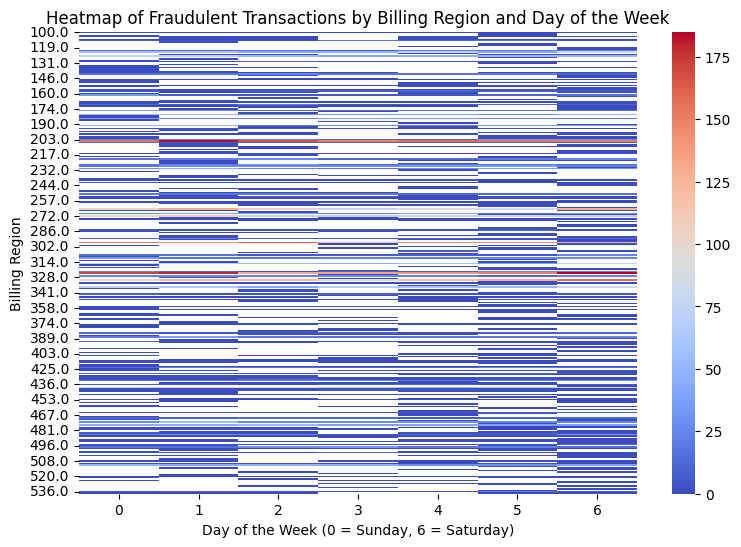

In [40]:
np.random.seed(42)
addr1_fraud_pivot = pd.pivot_table(trainDF, values='isFraud', index='addr1', columns='TransactionDayOfWeek', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(addr1_fraud_pivot, cmap='coolwarm', annot=False, cbar=True)
plt.title('Heatmap of Fraudulent Transactions by Billing Region and Day of the Week')
plt.xlabel('Day of the Week (0 = Sunday, 6 = Saturday)')
plt.ylabel('Billing Region')
plt.show()

**Visualization: Heatmap of Fraudulent Transactions by Billing Region and Day of Week**

<p style="font-size:10px">This heatmap is a visualization of fraudulent transactions in which each column represents a day of the week, each row represents a billing region, and color shades refer to transaction counts with red indicting a higher amount and blue indicating lower. </p>

<p style="font-size:10px">From this heatmap it can be seen that fraudulent transactions are not uniformally distributed across billing region or day of the week. Certain regions do show higher concentrations of fraud indicating a place where fraudsters might choose to make transactions the most. </p>